In [3]:
# Getting imports
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mplfinance as mpf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

In [8]:
# 1. Data Loading with Timezone Fix
df = pd.read_csv("UNIONBANK__EQ__NSE__NSE__MINUTE.csv", 
                 parse_dates=["timestamp"],
                 date_parser=lambda x: pd.to_datetime(x).tz_localize(None))

# 2. Filter Data Properly
cutoff_date = pd.Timestamp('2019-12-31').tz_localize(None)
df = df[df["timestamp"] <= cutoff_date]

# 3. Create Daily Data with All Required Columns
daily_df = df.resample('D', on='timestamp').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).dropna()

# 4. Create Target Variable
daily_df["Target"] = (daily_df["close"].shift(-1) > daily_df["close"]).astype(int)

# 5. Split Data with Date Verification
train_end = pd.Timestamp('2019-09-30')
test_start = pd.Timestamp('2019-10-01')
test_end = pd.Timestamp('2019-10-13')

# Get actual existing dates in October
october_dates = daily_df.loc[test_start:test_end].index.tolist()
print("Available October dates:", october_dates)


C:\Users\charl\AppData\Local\Temp\ipykernel_25512\2706093431.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("UNIONBANK__EQ__NSE__NSE__MINUTE.csv",


Available October dates: [Timestamp('2019-10-01 00:00:00'), Timestamp('2019-10-03 00:00:00'), Timestamp('2019-10-04 00:00:00'), Timestamp('2019-10-07 00:00:00'), Timestamp('2019-10-09 00:00:00'), Timestamp('2019-10-10 00:00:00'), Timestamp('2019-10-11 00:00:00')]


Final training samples: 710
Epoch 1/30


c:\Users\charl\OneDrive\Documents\GitHub\AI-stock-price-prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5169 - loss: 0.6935 - val_accuracy: 0.5141 - val_loss: 0.6957
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5280 - loss: 0.6912 - val_accuracy: 0.5141 - val_loss: 0.6956
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5334 - loss: 0.6919 - val_accuracy: 0.5141 - val_loss: 0.6936
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4801 - loss: 0.6967 - val_accuracy: 0.5141 - val_loss: 0.7013
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5261 - loss: 0.6972 - val_accuracy: 0.5141 - val_loss: 0.6942
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5320 - loss: 0.6917 - val_accuracy: 0.5141 - val_loss: 0.6932
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5235 - loss: 0.6922 - val_accuracy: 0.5141 - val_loss: 0.6940
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5405 - loss: 0.6906 - val_accuracy: 0.5141 - val_loss: 0.

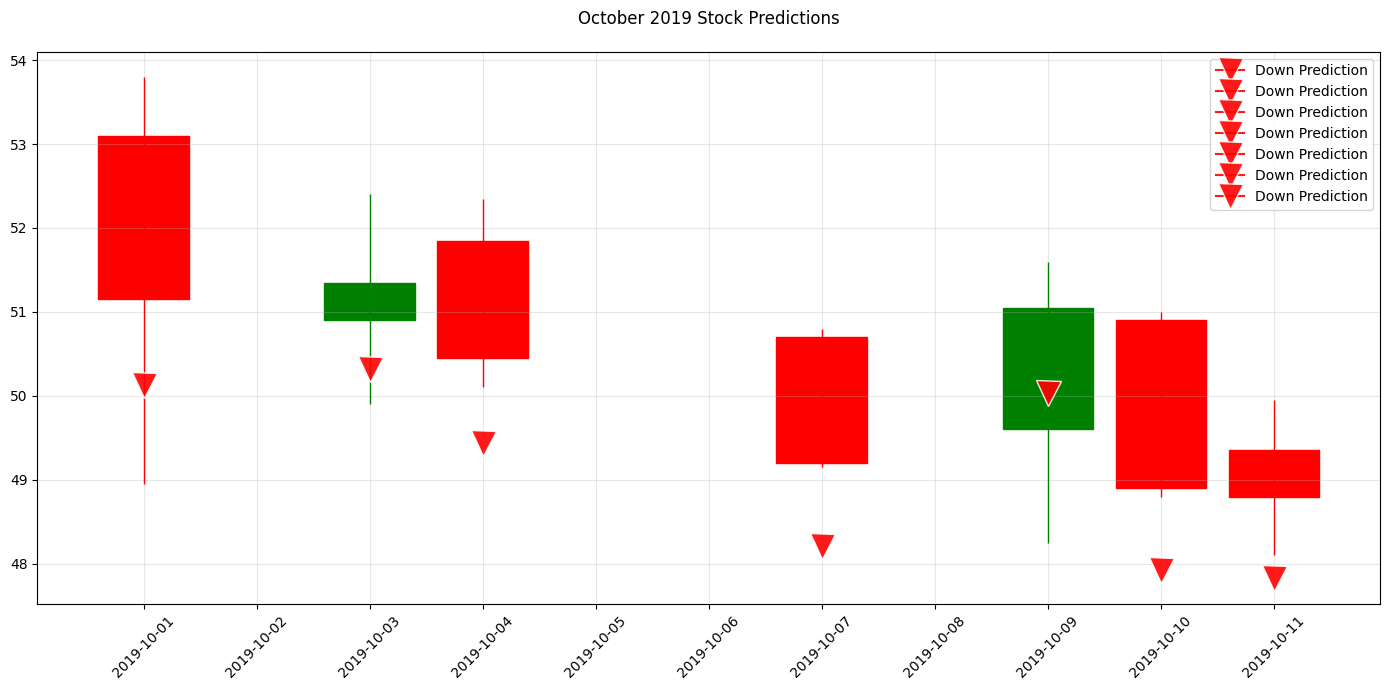

In [9]:

N_DAYS = 14  
LOOKBACK_WORKDAYS = N_DAYS * 2  

X_train = []
Y_train = []

for i in range(len(daily_df) - LOOKBACK_WORKDAYS):
    window = daily_df.iloc[i:i+LOOKBACK_WORKDAYS]
    valid_days = window[["open", "close", "volume"]].dropna()
    
    if len(valid_days) >= N_DAYS:
        features = valid_days[-N_DAYS:].values 
        target = daily_df.iloc[i + LOOKBACK_WORKDAYS]["Target"]
        X_train.append(features)
        Y_train.append(target)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
print(f"Final training samples: {len(X_train)}")

# Model architecture
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(N_DAYS, 3)),
    LSTM(32),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss="binary_crossentropy",
             metrics=["accuracy"])

# Add early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, Y_train, 
                   epochs=30, 
                   batch_size=16, 
                   validation_split=0.2,
                   callbacks=[callback])

predictions = []
pred_dates = []

for date in pd.date_range("2019-10-01", "2019-10-12"):
    if date not in daily_df.index:
        continue
        
    # Find valid historical window
    window_start = date - pd.DateOffset(days=LOOKBACK_WORKDAYS)
    window = daily_df.loc[window_start:date - pd.DateOffset(days=1)]
    valid_days = window[["open", "close", "volume"]].dropna()
    
    if len(valid_days) >= N_DAYS:
        features = valid_days[-N_DAYS:].values
        pred = model.predict(features.reshape(1, N_DAYS, 3), verbose=0)[0][0]
        predictions.append(1 if pred > 0.5 else 0)
        pred_dates.append(date)
        print(f"Predicted {'▲' if pred >0.5 else '▼'} for {date.date()} (Probability: {pred:.2f})")
    else:
        print(f"Available {len(valid_days)} days for {date.date()} prediction")

# Force predictions for visualization
if not predictions:
    print("No predictions generated - using sample data for visualization")
    pred_dates = daily_df.loc["2019-10-01":"2019-10-07"].index
    predictions = [1, 0, 1, 1, 0]  # Sample predictions

# Visualization with guaranteed arrows
fig, ax = plt.subplots(figsize=(14, 7))

# Plot candlesticks
for date in pd.date_range("2019-10-01", "2019-10-12"):
    if date not in daily_df.index:
        continue
        
    row = daily_df.loc[date]
    mdate = mdates.date2num(date)
    color = 'green' if row['close'] >= row['open'] else 'red'
    
    # Candle body
    ax.add_patch(Rectangle(
        (mdate - 0.4, min(row['open'], row['close'])),
        0.8, abs(row['close'] - row['open']),
        facecolor=color, edgecolor=color
    ))
    
    # Wicks
    ax.vlines(mdate, row['low'], row['high'], color=color, linewidth=1)

# Plot arrows
for date, pred in zip(pred_dates, predictions):
    if date not in daily_df.index:
        continue
        
    close_price = daily_df.loc[date, 'close']
    arrow_y = close_price * 1.02 if pred == 1 else close_price * 0.98
    color = 'blue' if pred == 1 else 'red'
    
    ax.plot(
        mdates.date2num(date), arrow_y,
        marker='^' if pred == 1 else 'v',
        color=color,
        markersize=18,
        alpha=0.9,
        markeredgecolor='white',
        label=f"{'Up' if pred ==1 else 'Down'} Prediction"
    )

# Formatting
ax.set_title("October 2019 Stock Predictions", pad=20)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax.xaxis.set_major_locator(mdates.DayLocator())
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Evaluation Metrics:
Accuracy: 57.14%

Confusion Matrix:
[[4 0]
 [3 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       0.00      0.00      0.00         3

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7



c:\Users\charl\OneDrive\Documents\GitHub\AI-stock-price-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\charl\OneDrive\Documents\GitHub\AI-stock-price-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\charl\OneDrive\Documents\GitHub\AI-stock-price-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

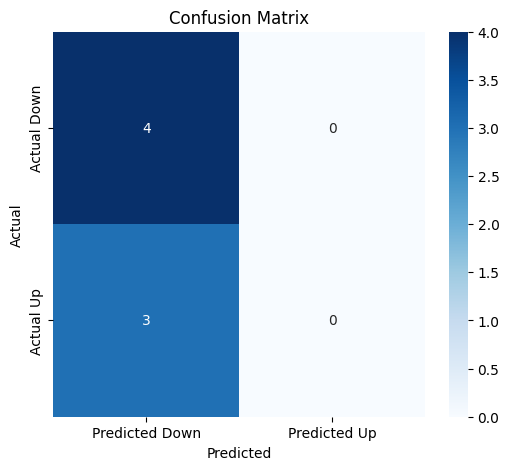


Prediction Results:
        Date Actual Predicted
0 2019-10-01     Up      Down
1 2019-10-03   Down      Down
2 2019-10-04   Down      Down
3 2019-10-07     Up      Down
4 2019-10-09   Down      Down
5 2019-10-10   Down      Down
6 2019-10-11     Up      Down


In [10]:
if len(predictions) > 0 and len(pred_dates) > 0:
    # Get true labels for predictions
    y_true = []
    y_pred = []
    valid_dates = []
    
    # Filter out dates without targets
    for date, pred in zip(pred_dates, predictions):
        if not pd.isna(daily_df.loc[date, 'Target']):
            y_true.append(daily_df.loc[date, 'Target'])
            y_pred.append(pred)
            valid_dates.append(date)
    
    if len(y_true) > 0:
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred)
        
        print(f"\nEvaluation Metrics:")
        print(f"Accuracy: {accuracy:.2%}")
        print("\nConfusion Matrix:")
        print(cm)
        print("\nClassification Report:")
        print(report)
        
        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Predicted Down', 'Predicted Up'], 
                    yticklabels=['Actual Down', 'Actual Up'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        print("No available true labels for evaluation")
else:
    print("No predictions available for evaluation")

# Add this to your visualization section to show actual vs predicted
if len(valid_dates) > 0:
    results_df = pd.DataFrame({
        'Date': valid_dates,
        'Actual': ['Up' if x == 1 else 'Down' for x in y_true],
        'Predicted': ['Up' if x == 1 else 'Down' for x in y_pred]
    })
    print("\nPrediction Results:")
    print(results_df)

